In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.fftpack import fft,ifft
from schrodinger import Schrodinger
import matplotlib.pyplot as plt
import scipy
import sympy as sp

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
import seaborn as sns

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('poster', font_scale=0.9,  rc={"lines.linewidth": 5})
sns.set_palette(sns.color_palette("deep"))

### Multi-valued wave function:

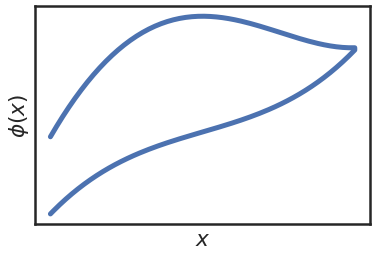

In [29]:
#define x grid:
x1 = np.linspace(-1,1,100)
x2 = np.linspace(1,-1,100)
y = x1**3 - x1**2 + np.cos(x1)**2
y = np.hstack((y,x2**3 + np.sin(x2)-1.6))
x = np.hstack((x1,x2))
plt.xticks([])
plt.yticks([])
plt.box(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi(x)$')
plt.plot(x,y)

In [5]:
#Specify initial wave function at grid points:
@np.vectorize
def psiF(x,n=1):
    k = np.pi*n/L
    f = np.sqrt(2/L)*np.sin(k*x)
    
    return  f

def energy(n=1):
    k = np.pi*n/L
    return hbar**2*k**2/(2*m)

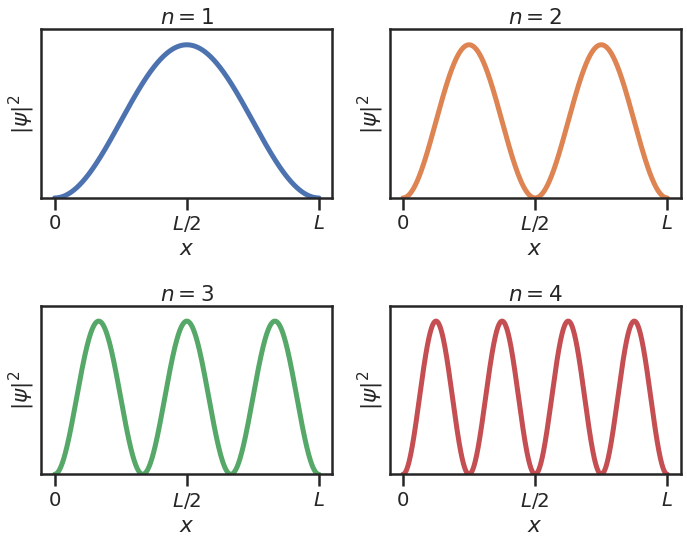

In [6]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(10,8))


n = 1
colors = sns.color_palette("deep", len(axs.reshape(-1)))
energies = []
for ax in axs.reshape(-1):
    energies.append(energy(n))
    ax.plot(x,psiF(x,n=n)**2,linestyle='-',label=r'$n=%i$' %n,c=colors[n-1])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$|\psi|^2$')
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([])
    ax.set_xticklabels([r'$0$',r'$L/2$',r'$L$'])
    ax.set_title(r'$n = %i$' %n)
    ax.set_ylim(0,1.1*np.max(psiF(x,n=1)**2))
    n += 1

plt.tight_layout()
plt.savefig('infiniteWellDensties.png')
plt.show()

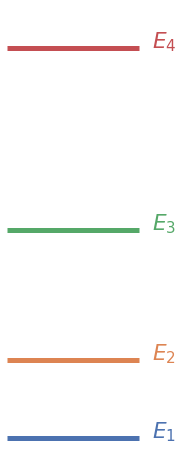

In [7]:
fig = plt.figure(figsize=(3,7))
for i,e in enumerate(energies):
    n = i+1
    plt.hlines(y=e,xmin=0.,xmax=1,colors=colors[n-1])
    plt.annotate(r'$E_{%i}$'%n, xy=(1.1,e),color=colors[n-1])
plt.xlim(0,1.1)
plt.ylim(0,1.1*max(energies))
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('infiniteWellEnergies.png')
plt.show()

In [8]:
@np.vectorize
def psi2(x,t):
    E1 = energy(n=1)
    f = np.sin(np.pi*x/L)**2
    f *= (1 + 4*np.cos(np.pi*x/L)**2 + 4*np.cos(np.pi*x/L)*np.cos(3*E1*t/hbar))
    return f/L

In [9]:
psi2(x=L/3,t=0),psi2(x=L/3,t=10)

(array(3.), array(0.40299885))

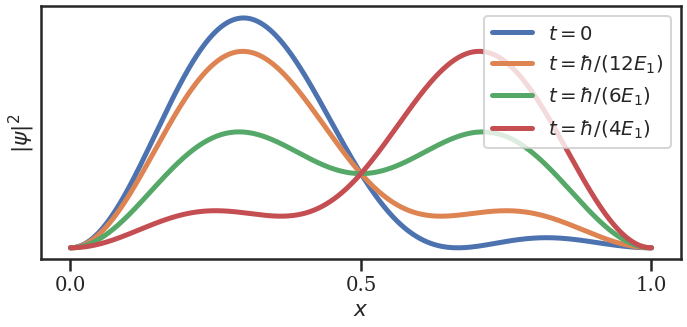

In [10]:
fig = plt.figure(figsize=(10,5))
E1 = energy(n=1)
plt.plot(x,psi2(x,t=0),label=r'$t=0$')
plt.plot(x,psi2(x,t=np.pi*hbar/(12*E1)),label=r'$t=\hbar/(12 E_1)$')
plt.plot(x,psi2(x,t=2*np.pi*hbar/(12*E1)),label=r'$t=\hbar/(6 E_1)$')
plt.plot(x,psi2(x,t=3*np.pi*hbar/(12*E1)),label=r'$t=\hbar/(4 E_1)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$|\psi|^2$')
plt.xticks([0,0.5,1])
plt.yticks([])
# plt.xticklabels([r'$0$',r'$L/2$',r'$L$'])
plt.legend()
plt.tight_layout()
plt.savefig('infiniteWellPackage.png')
plt.show()

In [11]:
psi_x0 = np.sqrt(1/L)*np.sin(np.pi*x/L) + np.sqrt(1/L)*np.sin(2*np.pi*x/L) 

### Animation:

In [19]:
######################################################################
# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,  psi_x0=psi_x0, V_x=V_x,
                    hbar=hbar, m=m)

# Set up plot
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,8))

psi_x_line, = ax1.plot([], [])
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|^2$')
title = ax1.set_title("")
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(0,max(np.abs(psi_x0)**2))
ax1.set_xticks([0,0.5,1])
ax1.set_yticks([])
ax1.set_xticklabels([r'$0$',r'$L/2$',r'$L$'])



# Animate plot
def init():
    psi_x_line.set_data([], [])
    title.set_text("")
    return (psi_x_line, title)

def animate(i):
    S.time_step(dt, N_steps)
    psi_x_line.set_data(S.x, psi2(S.x,t=S.t))

    title.set_text("t = %.2f" % S.t)
        
    return (psi_x_line, title)

# call the animator.  blit=True means only re-draw the parts that have changed.
dt = 0.001
N_steps = 1
E1 = energy(n=1)
t_max = 20.*np.pi*hbar/(12*E1)
frames = int(t_max / float(N_steps * dt))

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=100, blit=True)

#Para salvar corretamente, tem que descomentar a linha de baixo
anim.save('infiniteWellPackage.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

#Para ver o video no notebook deve comentar a linha de cima
plt.close()
anim
